# Init

In [234]:
# List of tickers for Korean stocks
tickers = {
    "삼성전자": "005930", "SK": "034730", "한화": "000880",
    "두산": "000150", "기아": "000270", "현대차": "005380",
    "LG": "003550", "NAVER": "035420", "카카오": "035720", "롯데지주": "004990"
}

# Date range for the stock data
start_date = "20200101"
end_date = "20250101"

In [235]:
# Target ticker for analysis
TARGET_TICKER = "삼성전자"
ticker_code = tickers[TARGET_TICKER]

In [236]:
import numpy as np
import torch

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

In [237]:
regression_model = True
target_column_name = "target"

# Train the model

### Load datasets

In [238]:
# Load the train, val, and test sets (list of DataFrames) from parquet files
import os
import json
import pandas as pd

dataset_dir = f"{ticker_code}_dataset"
train = []
val = []
test = []

if os.path.exists(dataset_dir):
    print(f"Loading dataset from {dataset_dir}/ directory...")
    
    # Load metadata
    with open(f"{dataset_dir}/metadata.json", 'r') as f:
        metadata = json.load(f)
    
    SEQ_LENGTH = metadata["seq_length"]
    print(f"Sequence length: {SEQ_LENGTH}")
    print(f"Ticker: {metadata['target_ticker']} ({metadata['ticker_code']})")
    assert SEQ_LENGTH > 0, "Sequence length must be greater than 0"
    assert ticker_code == metadata['ticker_code'], "Ticker code mismatch in metadata"
    assert TARGET_TICKER == metadata['target_ticker'], "Target ticker mismatch in metadata"
    
    # Load and reconstruct train set
    train_combined = pd.read_parquet(f"{dataset_dir}/train.parquet")
    for window_id in range(metadata["train_windows"]):
        window_df = train_combined[train_combined['window_id'] == window_id].drop('window_id', axis=1).reset_index(drop=True)
        train.append(window_df)
    
    # Load and reconstruct validation set
    val_combined = pd.read_parquet(f"{dataset_dir}/val.parquet")
    for window_id in range(metadata["val_windows"]):
        window_df = val_combined[val_combined['window_id'] == window_id].drop('window_id', axis=1).reset_index(drop=True)
        val.append(window_df)
    
    # Load and reconstruct test set
    test_combined = pd.read_parquet(f"{dataset_dir}/test.parquet")
    for window_id in range(metadata["test_windows"]):
        window_df = test_combined[test_combined['window_id'] == window_id].drop('window_id', axis=1).reset_index(drop=True)
        test.append(window_df)
    
    print(f"Loaded - Train windows: {len(train)}, Val windows: {len(val)}, Test windows: {len(test)}")
    print("Dataset loaded successfully!")
else:
    print(f"Dataset directory {dataset_dir} not found. Please run the dataset creation cells first.")


Loading dataset from 005930_dataset/ directory...
Sequence length: 10
Ticker: 삼성전자 (005930)
Loaded - Train windows: 728, Val windows: 236, Test windows: 236
Dataset loaded successfully!


### Check environments

In [239]:
# torch.cuda.is_available()
# torch.xpu.is_available()
print("--- PyTorch Version ---")
print(torch.__version__)
print("CUDA Available:", torch.cuda.is_available())
print("XPU Available:", torch.xpu.is_available())
device = 'cuda' if torch.cuda.is_available() else 'xpu' if torch.xpu.is_available() else 'cpu'

--- PyTorch Version ---
2.7.0+xpu
CUDA Available: False
XPU Available: True


### Create dataset loader

In [240]:
def create_xy(dataset):
    xs, ys = [], []
    for df in dataset:
        x = df.drop(columns=['date', target_column_name]).values
        y = df[target_column_name].iloc[-1]
        xs.append(x)
        ys.append(y)
        
    return np.array(xs), np.array(ys)

# Create xy datasets
train_x, train_y = create_xy(train)
val_x, val_y = create_xy(val)
test_x, test_y = create_xy(test)

train_x_tensor = torch.FloatTensor(train_x).to(device)
val_x_tensor = torch.FloatTensor(val_x).to(device)
test_x_tensor = torch.FloatTensor(test_x).to(device)

train_y_tensor = torch.LongTensor(train_y).to(device)
val_y_tensor = torch.LongTensor(val_y).to(device)
test_y_tensor = torch.LongTensor(test_y).to(device)
print("Train class counts:", np.bincount(train_y))

Train class counts: [123 483 122]


In [241]:
from torch.utils.data import TensorDataset, DataLoader

batch_size = 128
train_dataset = TensorDataset(train_x_tensor, train_y_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

eval_dataset = TensorDataset(val_x_tensor, val_y_tensor)
eval_loader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

test_dataset = TensorDataset(test_x_tensor, test_y_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

### Modeling

In [242]:
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=None, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha # 클래스 가중치 (alpha)
        self.reduction = reduction

    def forward(self, inputs, targets):
        # inputs: [N, C], targets: [N]
        CE_loss = F.cross_entropy(inputs, targets, reduction='none', weight=self.alpha)
        pt = torch.exp(-CE_loss)
        F_loss = (1 - pt)**self.gamma * CE_loss
        
        if self.reduction == 'mean':
            return F_loss.mean()
        elif self.reduction == 'sum':
            return F_loss.sum()
        else:
            return F_loss


In [243]:
import torch.nn as nn
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :] # type: ignore
        return self.dropout(x)

class TimeSeriesTransformer(nn.Module):
    # Changed num_classes to output_dim
    def __init__(self, input_dim, d_model, nhead, num_layers, output_dim=1, dropout=0.1):
        super(TimeSeriesTransformer, self).__init__()
        self.d_model = d_model
        self.encoder = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, d_model * 4, dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        # The decoder now outputs 1 continuous value
        self.decoder = nn.Linear(d_model, output_dim)

    def forward(self, src):
        src = self.encoder(src) * math.sqrt(self.d_model)
        src = src.permute(1, 0, 2)
        src = self.pos_encoder(src)
        src = src.permute(1, 0, 2)
        output = self.transformer_encoder(src)
        output = output[:, -1, :]
        output = self.decoder(output)
        return output

input_dim = train_x.shape[2]
d_model = 128
nhead = 4
num_layers = 4

model = TimeSeriesTransformer(
    input_dim=input_dim,
    d_model=d_model,
    nhead=nhead,
    num_layers=num_layers,
    output_dim=3,
    dropout=0.1
).to(device)

print("--- Transformer Model for Regression ---")
print(model)

--- Transformer Model for Regression ---
TimeSeriesTransformer(
  (encoder): Linear(in_features=35, out_features=128, bias=True)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (decoder): Linear(in_features=128, out_features=3, bias=True)
)


In [244]:
# Early Stopping Implementation
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta: float =0.0, path='checkpoint.pt'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose and \
            (self.counter == 1 or self.patience // 2 == self.counter or self.counter % 10 == 0):
                print(f'EarlyStopping counter: {self.counter}/{self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} -> {val_loss:.6f}). Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [245]:
# Loss function with class weights and optimizer
from torch.optim.lr_scheduler import ReduceLROnPlateau

class_counts = np.bincount(train_y)
weights = 1. / class_counts
weights = weights / weights.sum() 
weights_tensor = torch.FloatTensor(weights).to(device)
eval_class_counts = np.bincount(val_y)
eval_weights = 1. / eval_class_counts
eval_weights = eval_weights / eval_weights.sum()
eval_weights_tensor = torch.FloatTensor(eval_weights).to(device)
GAMMA = 0.6
criterion = FocalLoss(gamma=GAMMA, alpha=weights_tensor).to(device)
eval_criterion = FocalLoss(gamma=GAMMA, alpha=eval_weights_tensor).to(device)

# class_counts = np.bincount(train_y)
# total_samples = len(train_y)
# class_weights = total_samples / (len(class_counts) * class_counts)
# weights_tensor = torch.FloatTensor(class_weights).to(device)
# criterion = nn.CrossEntropyLoss(weight=weights_tensor)
# eval_class_counts = np.bincount(val_y)
# eval_total_samples = len(val_y)
# eval_class_weights = eval_total_samples / (len(eval_class_counts) * eval_class_counts)
# eval_weights_tensor = torch.FloatTensor(class_weights).to(device)
# eval_criterion = nn.CrossEntropyLoss(weight=eval_weights_tensor)


optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.01)
scheduler = ReduceLROnPlateau(optimizer, patience=5)

num_epochs = 1000

# EarlyStopping setting: if val_loss does not improve for 'patience' epochs, stop training
early_stopping = EarlyStopping(patience=20, verbose=True, path=f'{ticker_code}_best_model.pt')


print("\n--- Starting model training 🚀 ---")
for epoch in range(num_epochs):
    # Model training loop
    model.train()
    train_loss = 0.0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        output = model(batch_X)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Model evaluation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_X, batch_y in eval_loader:
            output = model(batch_X)
            loss = eval_criterion(output, batch_y)
            val_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(eval_loader)
    scheduler.step(avg_val_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}')
    
    # Early stopping check
    early_stopping(avg_val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping triggered. Stopping training.")
        break


--- Starting model training 🚀 ---
Epoch [1/1000], Train Loss: 0.136769, Val Loss: 0.082859
Validation loss decreased (inf -> 0.082859). Saving model ...
Epoch [2/1000], Train Loss: 0.149275, Val Loss: 0.101853
EarlyStopping counter: 1/20
Epoch [3/1000], Train Loss: 0.122978, Val Loss: 0.072900
Validation loss decreased (0.082859 -> 0.072900). Saving model ...
Epoch [4/1000], Train Loss: 0.115882, Val Loss: 0.091409
EarlyStopping counter: 1/20
Epoch [5/1000], Train Loss: 0.098298, Val Loss: 0.074548
Epoch [6/1000], Train Loss: 0.091911, Val Loss: 0.074987
Epoch [7/1000], Train Loss: 0.087746, Val Loss: 0.085858
Epoch [8/1000], Train Loss: 0.082835, Val Loss: 0.080577
Epoch [9/1000], Train Loss: 0.074005, Val Loss: 0.086392
Epoch [10/1000], Train Loss: 0.071100, Val Loss: 0.088269
Epoch [11/1000], Train Loss: 0.069383, Val Loss: 0.088606
Epoch [12/1000], Train Loss: 0.068128, Val Loss: 0.088854
Epoch [13/1000], Train Loss: 0.065643, Val Loss: 0.089923
EarlyStopping counter: 10/20
Epoch 

### Evaluation

In [246]:
from sklearn.metrics import (
    classification_report, 
    accuracy_score,
    mean_squared_error
)

model.load_state_dict(torch.load(f'{ticker_code}_best_model.pt'))


def eval(loader, calssification_report=False):
    # Loader for evaluation
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch_X, batch_y in loader:
            output = model(batch_X)
            output = torch.argmax(output, dim=1)
            all_preds.extend(output.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())

    # Calculate accuracy and classification report
    accuracy = accuracy_score(all_labels, all_preds)
    print(f'Accuracy: {accuracy:.4f}')
    if calssification_report:
        print(classification_report(all_labels, all_preds, target_names=['하락', '보합', '상승']))

print("\n--- Final evaluation with the best model ---")
print("--- Validation Set Metrics ---")
eval(eval_loader)
print("--- Test Set Metrics ---")
eval(test_loader, True)


--- Final evaluation with the best model ---
--- Validation Set Metrics ---
Accuracy: 0.1406
--- Test Set Metrics ---
Accuracy: 0.2031
              precision    recall  f1-score   support

          하락       0.08      0.29      0.13        17
          보합       0.00      0.00      0.00        81
          상승       0.31      0.70      0.43        30

    accuracy                           0.20       128
   macro avg       0.13      0.33      0.19       128
weighted avg       0.08      0.20      0.12       128



c:\Users\devwo\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\devwo\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\devwo\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


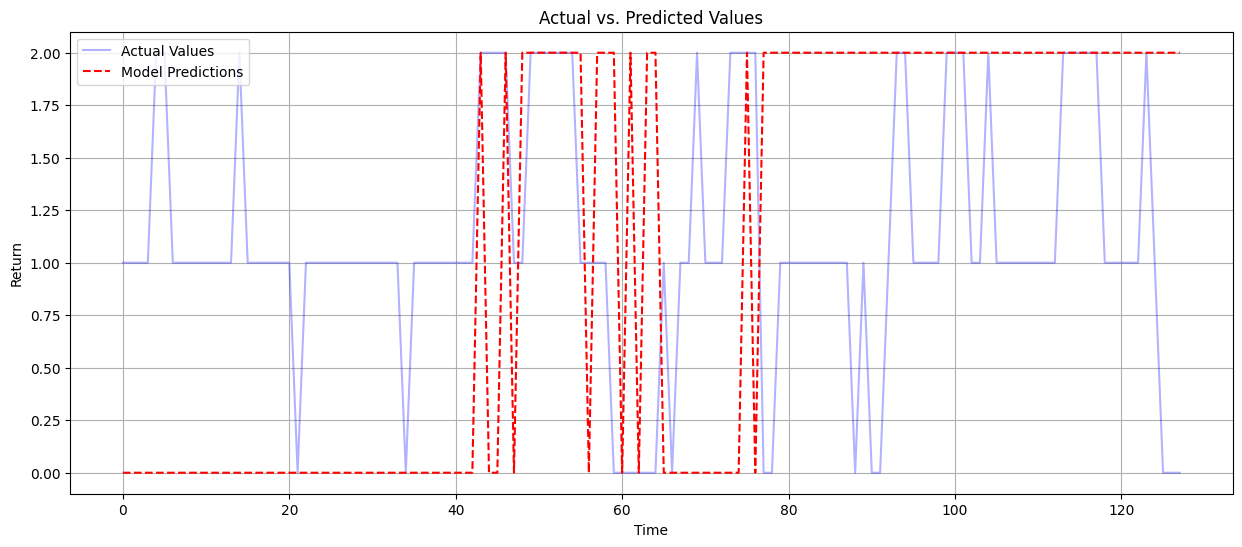

prediction_vs_actual.png 이미지 파일을 확인해보세요.


In [ ]:
import matplotlib.pyplot as plt

def get_predictions(loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch_X, batch_y in loader:
            output = model(batch_X)
            output = torch.argmax(output, dim=1)
            all_preds.extend(output.squeeze().cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())
    return np.array(all_labels), np.array(all_preds)

# true_values, predictions = get_predictions(train_loader)
true_values, predictions = get_predictions(test_loader)
# true_values = true_values[:10]
# predictions = predictions[:10]

plt.figure(figsize=(15, 6))
plt.plot(true_values, label='Actual Values', color='blue', alpha=0.3)
plt.plot(predictions, label='Model Predictions', color='red', linestyle='--')
plt.title('Actual vs. Predicted Values')
plt.xlabel('Time')
plt.ylabel('Return')
plt.legend()
plt.grid(True)
plt.savefig('prediction_vs_actual.png')
plt.show()

### After Resoning with Gemini

In [ ]:
# from google import genai
# from google.genai import types

# client = genai.Client()